In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
import os
PROJECT_DIR = "/content/drive/MyDrive/MIR/L3AC"
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)


Mounted at /content/drive


In [ ]:
#pysox manual install because it didng work with the regular pip install
!git clone https://github.com/rabitt/pysox.git
%cd pysox
!python setup.py install
%cd ..

import sox

Cloning into 'pysox'...
remote: Enumerating objects: 1534, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1534 (delta 47), reused 79 (delta 38), pack-reused 1425 (from 1)
Receiving objects: 100% (1534/1534), 4.23 MiB | 10.85 MiB/s, done.
Resolving deltas: 100% (1018/1018), done.
/content/drive/MyDrive/MIR/L3AC/pysox/pysox/pysox/pysox
No `name` configuration, performing automatic discovery
running install
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ******************************************************

In [ ]:
!pip install -q l3ac librosa soundfile scikit-learn
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q pandas matplotlib seaborn tqdm
# Install required packages
!pip install -q l3ac librosa soundfile scikit-learn torch torchvision torchaudio
!pip install -q accelerate tensorboard pandas matplotlib seaborn tqdm
!pip install -q huggingface_hub

# For training L3AC (if needed)
!pip install -q einops pynvml pydantic-settings

print(" Installation complete!")

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/sox-1.5.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/sox-1.5.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/sox-1.5.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/sox-1.5.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible 

In [ ]:
import os
import urllib.request
import zipfile
from pathlib import Path

import librosa
import soundfile as sf
import glob
import numpy as np

import itertools
import json
from collections import defaultdict

import sox
import numpy as np

from pathlib import Path
import torch
import l3ac
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import GroupShuffleSplit

import pickle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import torchaudio

from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
#you would run this to download and split the guitarset
"""
import urllib.request
import zipfile
from pathlib import Path
import librosa
import soundfile as sf
import glob
import numpy as np

# Create directories
DATASET_DIR = Path(PROJECT_DIR) / "datasets"
GUITARSET_DIR = DATASET_DIR / "guitarset"
CLEAN_DIR = GUITARSET_DIR / "clean"
RENDERED_DIR = GUITARSET_DIR / "rendered"

for dir_path in [DATASET_DIR, GUITARSET_DIR, CLEAN_DIR, RENDERED_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Download GuitarSet
print("Downloading GuitarSet dataset...")
guitarset_url = "https://zenodo.org/record/3371780/files/audio_mono-mic.zip?download=1"
zip_path = GUITARSET_DIR / "audio_mono-mic.zip"

if not zip_path.exists():
    urllib.request.urlretrieve(guitarset_url, zip_path)
    print(" Downloaded GuitarSet")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(GUITARSET_DIR)
    print(" Extracted GuitarSet")
else:
    print(" GuitarSet already downloaded")

# Process and slice audio into 5-second segments
SEGMENT_DURATION = 5.0
SAMPLE_RATE = 16000  # L3AC uses 16kHz

audio_files = glob.glob(str(GUITARSET_DIR / "audio_mono-mic" / "*.wav"))
print(f"Found {len(audio_files)} audio files")

clean_segments = []

# Process first 30 files to keep dataset manageable
for idx, audio_file in enumerate(audio_files[:30]):
    try:
        audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE, mono=True)

        # Slice into 5-second segments
        segment_samples = int(SEGMENT_DURATION * SAMPLE_RATE)
        num_segments = len(audio) // segment_samples

        for seg_idx in range(num_segments):
            start = seg_idx * segment_samples
            end = start + segment_samples
            segment = audio[start:end]

            # Normalize
            segment = segment / (np.max(np.abs(segment)) + 1e-8)

            # Save segment
            seg_filename = f"seg_{idx:03d}_{seg_idx:03d}.wav"
            seg_path = CLEAN_DIR / seg_filename
            sf.write(seg_path, segment, SAMPLE_RATE)
            clean_segments.append(str(seg_path))

    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

print(f" Created {len(clean_segments)} clean segments")
"""

In [ ]:
#you would run this to define guitar effects and gnereate chains
"""
import itertools
import json

# Define effects following DAFx paper methodology
EFFECTS = {
    'nonlinear': {
        'overdrive': {'func': 'overdrive', 'params': {'gain_db': 5}},
        'distortion': {'func': 'overdrive', 'params': {'gain_db': 15}},
    },
    'modulation': {
        'chorus': {'func': 'chorus', 'params': {'n_voices': 5}},
        'flanger': {'func': 'flanger', 'params': {'depth': 5, 'phase': 50}},
        'phaser': {'func': 'phaser', 'params': {}},
        'tremolo': {'func': 'tremolo', 'params': {}},
    },
    'ambience': {
        'reverb': {'func': 'reverb', 'params': {'reverberance': 80}},
    },
    'delay': {
        'feedback_delay': {'func': 'echos', 'params': {'n_echos': 3, 'delays': [200,400,600],
                                                         'decays':[0.4,0.2,0.1], 'gain_out':0.5}},
        'slapback_delay': {'func': 'echo', 'params': {'n_echos': 3, 'delays': [200,400,600],
                                                        'decays':[0.4,0.2,0.1], 'gain_out':0.5}},
    },
    'eq': {
        'low_boost': {'func': 'bass', 'params': {'frequency': 200, 'gain_db': 10}},
        'low_reduct': {'func': 'bass', 'params': {'frequency': 200, 'gain_db': -10}},
        'high_boost': {'func': 'treble', 'params': {'frequency': 8000, 'gain_db': 20}},
        'high_reduct': {'func': 'treble', 'params': {'frequency': 8000, 'gain_db': -20}},
    }
}

# Create flat effect list and group structure
ALL_EFFECTS = []
EFFECT_GROUPS = []

for group_name, effects_dict in EFFECTS.items():
    group_effects = []
    for effect_name in effects_dict.keys():
        ALL_EFFECTS.append(effect_name)
        group_effects.append(len(ALL_EFFECTS) - 1)
    EFFECT_GROUPS.append(group_effects)

print(f"Total effects: {len(ALL_EFFECTS)}")
print(f"Effects: {ALL_EFFECTS}")

# Generate effect chains (1-5 groups, mutually exclusive within groups)
def generate_effect_chains(num_groups_range=(1, 5)):
    chains = []
    for num_groups in range(num_groups_range[0], num_groups_range[1] + 1):
        for group_combo in itertools.combinations(range(len(EFFECT_GROUPS)), num_groups):
            selected_groups = [EFFECT_GROUPS[g] for g in group_combo]
            for effect_combo in itertools.product(*selected_groups):
                chains.append(list(effect_combo))
    return chains

effect_chains = generate_effect_chains()
print(f" Generated {len(effect_chains)} effect chain combinations")

# Limit to first 30 chains for faster processing
effect_chains = effect_chains[:30]
print(f"Using {len(effect_chains)} effect chains for this experiment")
"""

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/MIR/L3AC"
DATASET_DIR = Path(PROJECT_DIR) / "datasets"
GUITARSET_DIR = DATASET_DIR / "guitarset"
CLEAN_DIR = GUITARSET_DIR / "clean"
RENDERED_DIR = GUITARSET_DIR / "rendered"

print(f"Project directory: {PROJECT_DIR}")
print(f"Clean audio directory: {CLEAN_DIR}")
print(f"Rendered audio directory: {RENDERED_DIR}")

# Verify directories exist and create if needed
for dir_path in [DATASET_DIR, GUITARSET_DIR, CLEAN_DIR, RENDERED_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    if dir_path.exists():
        print(f"✓ {dir_path.name} exists")

clean_files_check = list(CLEAN_DIR.glob("*.wav"))
print(f" found {len(clean_files_check)} clean audio files")

#Effects defintions from DAFx paper
EFFECTS = {
    'nonlinear': {
        'overdrive': {'func': 'overdrive', 'params': {'gain_db': 5}},
        'distortion': {'func': 'overdrive', 'params': {'gain_db': 15}},
    },
    'modulation': {
        'chorus': {'func': 'chorus', 'params': {'n_voices': 5}},
        'flanger': {'func': 'flanger', 'params': {'depth': 5, 'phase': 50}},
        'phaser': {'func': 'phaser', 'params': {}},
        'tremolo': {'func': 'tremolo', 'params': {}},
    },
    'ambience': {
        'reverb': {'func': 'reverb', 'params': {'reverberance': 80}},
    },
    'delay': {
        'feedback_delay': {'func': 'echos', 'params': {'n_echos': 3, 'delays': [200,400,600],
                                                         'decays':[0.4,0.2,0.1], 'gain_out':0.5}},
        'slapback_delay': {'func': 'echo', 'params': {'n_echos': 3, 'delays': [200,400,600],
                                                        'decays':[0.4,0.2,0.1], 'gain_out':0.5}},
    },
    'eq': {
        'low_boost': {'func': 'bass', 'params': {'frequency': 200, 'gain_db': 10}},
        'low_reduct': {'func': 'bass', 'params': {'frequency': 200, 'gain_db': -10}},
        'high_boost': {'func': 'treble', 'params': {'frequency': 8000, 'gain_db': 20}},
        'high_reduct': {'func': 'treble', 'params': {'frequency': 8000, 'gain_db': -20}},
    }
}

# Flat effects lists
ALL_EFFECTS = []
EFFECT_GROUPS = []

for group_name, effects_dict in EFFECTS.items():
    group_effects = []
    for effect_name in effects_dict.keys():
        ALL_EFFECTS.append(effect_name)
        group_effects.append(len(ALL_EFFECTS) - 1)
    EFFECT_GROUPS.append(group_effects)

print(f"\n✓ Total effects: {len(ALL_EFFECTS)}")
print(f"✓ Effect list: {ALL_EFFECTS}")
print(f"✓ Effect groups: {EFFECT_GROUPS}")

# create effects chainsf
import itertools

def generate_effect_chains(num_groups_range=(1, 5)):
    """Generate all combinations of effect chains (1-5 groups)."""
    chains = []
    for num_groups in range(num_groups_range[0], num_groups_range[1] + 1):
        for group_combo in itertools.combinations(range(len(EFFECT_GROUPS)), num_groups):
            selected_groups = [EFFECT_GROUPS[g] for g in group_combo]
            for effect_combo in itertools.product(*selected_groups):
                chains.append(list(effect_combo))
    return chains

#up to 455 chain combinations, limit to 30 for dataset manageability
effect_chains = generate_effect_chains()
print(f"\nGenerated {len(effect_chains)} total effect chain combinations")
print(f" Will use first 30 chains: {len(effect_chains[:30])} chains")

# Show a few example chains
print("\nExample effect chains:")
for i, chain in enumerate(effect_chains[:3]):
    effect_names = [ALL_EFFECTS[idx] for idx in chain]
    print(f"  Chain {i}: {effect_names}")

# Get all clean segment files
clean_segments = sorted(glob.glob(str(CLEAN_DIR / "*.wav")))

if len(clean_segments) == 0:
    print("\n No clean segments found!")
else:
    print(f"\n Found {len(clean_segments)} clean audio segments")
    print(f"  First segment: {Path(clean_segments[0]).name}")
    print(f"  Last segment: {Path(clean_segments[-1]).name}")

#verify setup
print(" All variables defined successfully!")
print("\nDefined variables:")
print(f"  - PROJECT_DIR: {PROJECT_DIR}")
print(f"  - DATASET_DIR: {DATASET_DIR}")
print(f"  - CLEAN_DIR: {CLEAN_DIR}")
print(f"  - RENDERED_DIR: {RENDERED_DIR}")
print(f"  - EFFECTS: dict with {len(EFFECTS)} groups")
print(f"  - ALL_EFFECTS: list with {len(ALL_EFFECTS)} effects")
print(f"  - EFFECT_GROUPS: list with {len(EFFECT_GROUPS)} groups")
print(f"  - effect_chains: list with {len(effect_chains)} chains (using first 50)")
print(f"  - clean_segments: list with {len(clean_segments)} audio files")

Project directory: /content/drive/MyDrive/MIR/L3AC
Clean audio directory: /content/drive/MyDrive/MIR/L3AC/datasets/guitarset/clean
Rendered audio directory: /content/drive/MyDrive/MIR/L3AC/datasets/guitarset/rendered
✓ datasets exists
✓ guitarset exists
✓ clean exists
✓ rendered exists
 found 1988 clean audio files

✓ Total effects: 13
✓ Effect list: ['overdrive', 'distortion', 'chorus', 'flanger', 'phaser', 'tremolo', 'reverb', 'feedback_delay', 'slapback_delay', 'low_boost', 'low_reduct', 'high_boost', 'high_reduct']
✓ Effect groups: [[0, 1], [2, 3, 4, 5], [6], [7, 8], [9, 10, 11, 12]]

Generated 449 total effect chain combinations
 Will use first 30 chains: 30 chains

Example effect chains:
  Chain 0: ['overdrive']
  Chain 1: ['distortion']
  Chain 2: ['chorus']

 Found 1988 clean audio segments
  First segment: 00_BN1-129-Eb_comp_mic_seg_125_000.wav
  Last segment: 05_SS3-98-C_solo_mic_seg_261_006.wav
 All variables defined successfully!

Defined variables:
  - PROJECT_DIR: /conten

In [ ]:
#metadata reconstrcution script because i already have the rendered data

print(f"Scanning {RENDERED_DIR} for existing rendered files")
rendered_files = sorted(list(RENDERED_DIR.glob("*.wav")))
print(f"Found {len(rendered_files)} files.")

if len(rendered_files) == 0:
    print("No files found")
else:
    reconstructed_data = []
    print("Reconstructing metadata from filenames")

    # Ensure ALL_EFFECTS is available (from Setup cell)
    if 'ALL_EFFECTS' not in globals():
        print(" ALL_EFFECTS not defined. Remember to run the setup cells you dingus.")
    else:
        for file_path in tqdm(rendered_files):
            try:
                filename = file_path.name

                # Expected filename format: {clean_stem}__{effect_string}.wav
                if "__" not in filename:
                    continue

                # Use rpartition to safely split at the last double underscore
                clean_stem, sep, effect_str_ext = filename.rpartition("__")
                if not sep:
                    continue

                effect_str = effect_str_ext.replace(".wav", "")

                # Parse effect names from the string
                # Logic: Accumulate tokens split by '_' until they match a known effect
                tokens = effect_str.split('_')
                detected_effects = []
                current_token_parts = []

                for token in tokens:
                    current_token_parts.append(token)
                    candidate = "_".join(current_token_parts)
                    if candidate in ALL_EFFECTS:
                        detected_effects.append(candidate)
                        current_token_parts = []

                # Validate
                if not detected_effects and effect_str != "":
                    # Could not parse effects, skip
                    continue

                # Map names to indices
                effect_indices = []
                for eff in detected_effects:
                    if eff in ALL_EFFECTS:
                        effect_indices.append(ALL_EFFECTS.index(eff))

                # Create multi-hot label
                label = np.zeros(len(ALL_EFFECTS), dtype=int)
                for idx in effect_indices:
                    label[idx] = 1

                # Reconstruct path to original clean file (Best guess)
                clean_path = CLEAN_DIR / f"{clean_stem}.wav"

                reconstructed_data.append({
                    'clean_path': str(clean_path),
                    'rendered_path': str(file_path),
                    'effect_chain': effect_indices,
                    'label': label.tolist(),
                    'effect_names': detected_effects
                })

            except Exception as e:
                print(f"Error parsing {file_path.name}: {e}")

        print(f"\nSuccessfully reconstructed metadata for {len(reconstructed_data)} samples.")

        #group based splitting
        print("Creating train/test split based on Original Stems (Groups)...")
        groups = []
        for item in reconstructed_data:
            # item['clean_path'] is like: .../seg_00_BN1-129-Eb_comp_mic_000.wav
            # We want '00_BN1-129-Eb_comp_mic' as the group ID
            fname = Path(item['clean_path']).stem # seg_00_BN1..._000

            # Remove 'seg_' prefix if present
            if fname.startswith("seg_"):
                fname = fname[4:]

            # Remove segment index suffix (last underscore and digits)
            stem_part, sep, seg_idx = fname.rpartition("_")
            if sep and seg_idx.isdigit():
                group_id = stem_part
            else:
                group_id = fname

            groups.append(group_id)

        groups = np.array(groups)
        n_groups = len(np.unique(groups))
        print(f"Identified {n_groups} unique original recordings (stems).")

        # Perform Group Split
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, test_idx = next(splitter.split(reconstructed_data, groups=groups))

        # Save indices and metadata
        metadata_path = DATASET_DIR / "rendered_metadata.pkl"
        with open(metadata_path, 'wb') as f:
            pickle.dump(reconstructed_data, f)

        np.save(DATASET_DIR / "train_indices.npy", train_idx)
        np.save(DATASET_DIR / "test_indices.npy", test_idx)

        print(f" Saved metadata and split indices.")
        print(f"  Train samples: {len(train_idx)}")
        print(f"  Test samples: {len(test_idx)}")

        # Assign to global variable so next cells can use it immediately
        rendered_data = reconstructed_data

Scanning /content/drive/MyDrive/MIR/L3AC/datasets/guitarset/rendered for existing rendered files
Found 4579 files.
Reconstructing metadata from filenames


100%|██████████| 4579/4579 [00:00<00:00, 66721.74it/s]


Successfully reconstructed metadata for 4579 samples.
Creating train/test split based on Original Stems (Groups)...
Identified 36 unique original recordings (stems).
 Saved metadata and split indices.
  Train samples: 3404
  Test samples: 1175


In [ ]:
# Install L3AC from source
!pip install -q git+https://github.com/zhai-lw/L3AC.git

import torch
import l3ac

# Load the pretrained codec using the library's built-in function
MODEL_NAME = "3kbps"  # Options: 750bps, 1kbps, 1.5kbps, 3kbps

print(f"Loading L3AC model: {MODEL_NAME}")

# Use built-in loader which handles download automatically
codec = l3ac.get_model(MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
# l3ac.get_model returns a wrapper, the actual torch module is often in .network
if hasattr(codec, 'network'):
    codec.network.to(device)
    codec.network.eval()
else:
    codec.to(device)
    codec.eval()

print(f"Loaded L3AC codec on {device}")

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/sox-1.5.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Loading L3AC model: 3kbps


Loaded L3AC codec on cuda


In [ ]:
import torch
import l3ac
import numpy as np
from tqdm import tqdm

# Load L3AC model check
print(f"Sample rate: {codec.config.sample_rate} Hz")

def extract_l3ac_encoder_features(audio_path, codec, device, debug_shape=False):
    """
    Extract continuous encoder features from L3AC (before quantization).
    """
    # Load audio
    audio, sr = librosa.load(audio_path, sr=codec.config.sample_rate, mono=True)
    audio_tensor = torch.tensor(audio[None, :], dtype=torch.float32, device=device)

    with torch.inference_mode():
        # Get encoder features (continuous representation)
        q_feature, indices = codec.encode_audio(audio_tensor)
        # Expected shape: (Batch, Time, Channels) or (Batch, Channels, Time)

        encoder_features = q_feature.cpu().numpy()

        if debug_shape:
            print(f"Raw feature shape: {encoder_features.shape}")

        # We want to aggregate over TIME to get fixed-size statistics per channel.
        # If shape is (1, T, C), axis=1 is Time.
        # If shape is (1, C, T), axis=2 is Time.
        # Based on the error (variable length results), the previous code reduced the WRONG axis.
        # Assuming (1, T, C) -> Reduce axis 1.

        time_axis = 1
        # If the last dimension is small (e.g. 512) and middle is varying (time), this is correct.

        # Aggregate features: mean and std across time
        feat_mean = encoder_features.mean(axis=time_axis).flatten()  # [channels]
        feat_std = encoder_features.std(axis=time_axis).flatten()    # [channels]
        feat_max = encoder_features.max(axis=time_axis).flatten()    # [channels]
        feat_min = encoder_features.min(axis=time_axis).flatten()    # [channels]

        # Concatenate statistics
        features = np.concatenate([feat_mean, feat_std, feat_max, feat_min])

    return features

# Extract features for all rendered samples
print("Extracting L3AC encoder features...")
all_features = []
all_labels = []

if 'rendered_data' not in globals() or len(rendered_data) == 0:
    print("\n'rendered_data' is empty or not defined!")
else:
    # Debug first sample to verify shape
    try:
        print("\n--- Debugging first sample ---")
        sample0 = rendered_data[0]
        feat0 = extract_l3ac_encoder_features(sample0['rendered_path'], codec, device, debug_shape=True)
        print(f"Extracted feature vector shape: {feat0.shape}")
        print("--------------------------------\n")
    except Exception as e:
        print(f"Debug failed: {e}")

    # Process all
    for sample in tqdm(rendered_data):
        try:
            features = extract_l3ac_encoder_features(sample['rendered_path'], codec, device)
            all_features.append(features)
            all_labels.append(sample['label'])
        except Exception as e:
            print(f"\nError with {sample['rendered_path']}: {e}")

    try:
        all_features = np.array(all_features)
        all_labels = np.array(all_labels)

        print(f"\n Extracted features shape: {all_features.shape}")
        print(f" Labels shape: {all_labels.shape}")

        if len(all_features) > 0:
            # Save features
            np.save(DATASET_DIR / "l3ac_features.npy", all_features)
            np.save(DATASET_DIR / "labels.npy", all_labels)
            print(" Features and labels saved")
        else:
            print(" No features extracted.")

    except ValueError as e:
        print(f"\n ERROR forming array: {e}")
        print("Checking feature lengths...")
        lengths = [len(f) for f in all_features[:10]]
        print(f"Lengths of first 10 samples: {lengths}")

Sample rate: 16000 Hz
Extracting L3AC encoder features...

--- Debugging first sample ---
Raw feature shape: (1, 844, 128)
Extracted feature vector shape: (512,)
--------------------------------



100%|██████████| 4579/4579 [01:08<00:00, 66.56it/s]



 Extracted features shape: (4579, 512)
 Labels shape: (4579, 13)
 Features and labels saved


In [ ]:
# Load features and labels
all_features = np.load(DATASET_DIR / "l3ac_features.npy")
all_labels = np.load(DATASET_DIR / "labels.npy")

# group split
print("Loading group-based split indices...")
train_idx = np.load(DATASET_DIR / "train_indices.npy")
test_idx = np.load(DATASET_DIR / "test_indices.npy")

X_train = all_features[train_idx]
y_train = all_labels[train_idx]
X_test = all_features[test_idx]
y_test = all_labels[test_idx]

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define MLP model (following DAFx paper architecture)
class EffectClassifierMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Dataset class
class EffectDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataloaders
train_dataset = EffectDataset(X_train_scaled, y_train)
test_dataset = EffectDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model
model = EffectClassifierMLP(input_dim=X_train_scaled.shape[1],
                              num_classes=len(ALL_EFFECTS))
model.to(device)

print(f"\nModel architecture:\n{model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
print("\n" + "="*60)
print("TRAINING MLP CLASSIFIER")
print("="*60)

num_epochs = 100
best_f1 = 0.0
patience = 10
patience_counter = 0

train_losses = []
test_f1_scores = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for features_batch, labels_batch in train_loader:
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(features_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    all_preds = []
    all_labels_eval = []

    with torch.no_grad():
        for features_batch, labels_batch in test_loader:
            features_batch = features_batch.to(device)
            outputs = model(features_batch)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.append(preds)
            all_labels_eval.append(labels_batch.numpy())

    all_preds = np.vstack(all_preds)
    all_labels_eval = np.vstack(all_labels_eval)

    # Calculate F1 scores
    micro_f1 = f1_score(all_labels_eval, all_preds, average='micro')
    macro_f1 = f1_score(all_labels_eval, all_preds, average='macro')
    test_f1_scores.append(macro_f1)

    # Early stopping
    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), DATASET_DIR / "best_mlp_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Loss: {avg_train_loss:.4f}")

Loading group-based split indices...
Train set: (3404, 512), Test set: (1175, 512)

Model architecture:
EffectClassifierMLP(
  (network): Sequential(
    (0): Linear(in_features=512, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4096, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=13, bias=True)
  )
)
Total parameters: 4,205,581

TRAINING MLP CLASSIFIER
Epoch [10/100]
  Loss: 0.0651
Epoch [20/100]
  Loss: 0.0342
Epoch [30/100]
  Loss: 0.0281
Epoch [40/100]
  Loss: 0.0283
Epoch [50/100]
  Loss: 0.0230
Epoch [60/100]
  Loss: 0.0173
Epoch [70/100]
  Loss: 0.0305
Epoch [80/100]
  Loss: 0.0218
Epoch [90/100]
  Loss: 0.0244
Epoch [100/100]
  Loss: 0.0166


FINAL EVALUATION RESULTS
Micro F1: 0.6025
Macro F1: 0.5431

Per-class F1 scores:
  overdrive           : 0.5802
  distortion          : 0.7978
  chorus              : 0.6134
  flanger             : 0.4143
  phaser              : 0.4775
  tremolo             : 0.3548
  reverb              : 0.6225
  feedback_delay      : 0.9792
  slapback_delay      : 0.7034
  low_boost           : 0.7143
  low_reduct          : 0.6494
  high_boost          : 0.0000
  high_reduct         : 0.1538


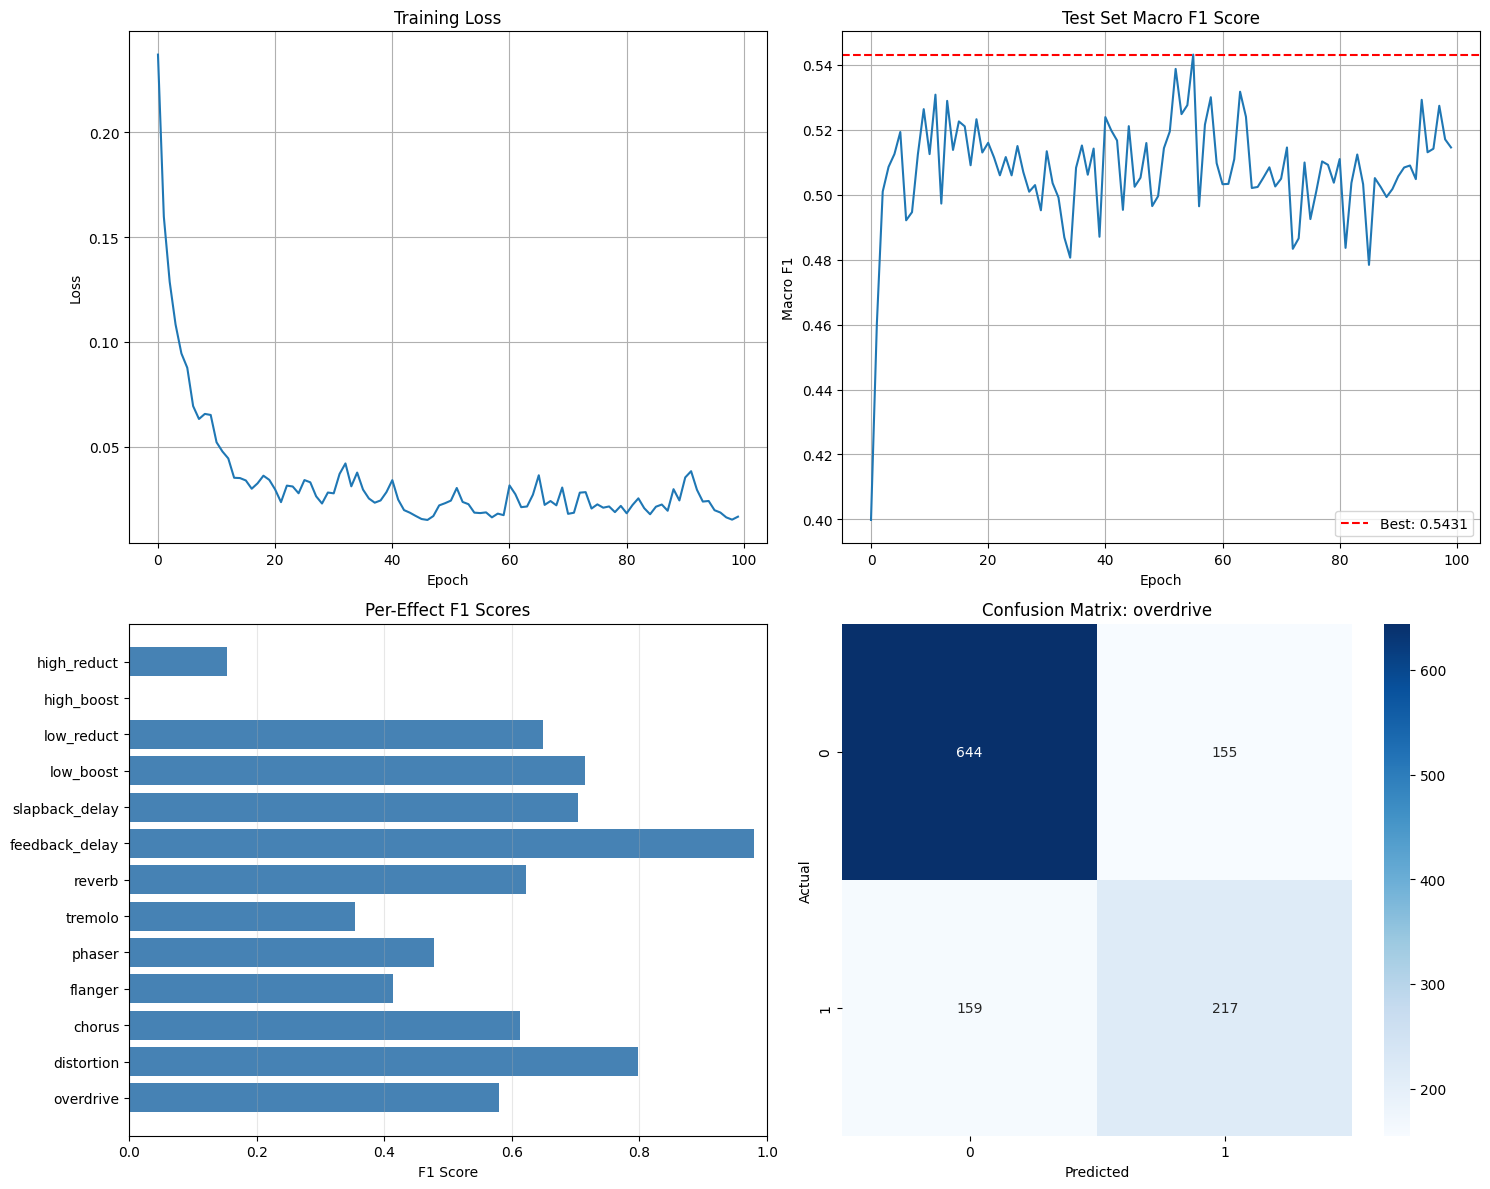


 Results saved to /content/drive/MyDrive/MIR/L3AC


In [ ]:
# Load best model
model.load_state_dict(torch.load(DATASET_DIR / "best_mlp_model.pth"))
model.eval()

# Final evaluation
all_preds_final = []
all_labels_final = []

with torch.no_grad():
    for features_batch, labels_batch in test_loader:
        features_batch = features_batch.to(device)
        outputs = model(features_batch)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds_final.append(preds)
        all_labels_final.append(labels_batch.numpy())

all_preds_final = np.vstack(all_preds_final)
all_labels_final = np.vstack(all_labels_final)

# Calculate metrics
micro_f1_final = f1_score(all_labels_final, all_preds_final, average='micro')
macro_f1_final = f1_score(all_labels_final, all_preds_final, average='macro')
per_class_f1 = f1_score(all_labels_final, all_preds_final, average=None)

print("="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)
print(f"Micro F1: {micro_f1_final:.4f}")
print(f"Macro F1: {macro_f1_final:.4f}")
print(f"\nPer-class F1 scores:")
for effect, f1 in zip(ALL_EFFECTS, per_class_f1):
    print(f"  {effect:20s}: {f1:.4f}")

# Save results
results = {
    'micro_f1': micro_f1_final,
    'macro_f1': macro_f1_final,
    'per_class_f1': per_class_f1,
    'predictions': all_preds_final,
    'labels': all_labels_final,
    'effect_names': ALL_EFFECTS
}

with open(DATASET_DIR / "final_results.pkl", 'wb') as f:
    pickle.dump(results, f)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training loss curve
axes[0, 0].plot(train_losses)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].grid(True)

# 2. Test F1 score curve
axes[0, 1].plot(test_f1_scores)
axes[0, 1].axhline(y=best_f1, color='r', linestyle='--', label=f'Best: {best_f1:.4f}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Macro F1')
axes[0, 1].set_title('Test Set Macro F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# 3. Per-class F1 scores
axes[1, 0].barh(ALL_EFFECTS, per_class_f1, color='steelblue')
axes[1, 0].set_xlabel('F1 Score')
axes[1, 0].set_title('Per-Effect F1 Scores')
axes[1, 0].set_xlim([0, 1])
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Confusion matrix for one effect (e.g., overdrive)
effect_idx = 0  # overdrive
cm = multilabel_confusion_matrix(all_labels_final, all_preds_final)[effect_idx]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix: {ALL_EFFECTS[effect_idx]}')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout()

# Fix: Convert PROJECT_DIR string to Path object before using '/'
plt.savefig(Path(PROJECT_DIR) / "training_results.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Results saved to {PROJECT_DIR}")

In [ ]:
# Prepare audio file list for fine-tuning
finetune_data = []

print("Preparing fine-tuning dataset...")

# Ensure we have metadata and split indices
if 'rendered_data' not in globals():
    import pickle
    with open(DATASET_DIR / "rendered_metadata.pkl", 'rb') as f:
        rendered_data = pickle.load(f)

# Load training indices to prevent data leakage
if (DATASET_DIR / "train_indices.npy").exists():
    train_idx = np.load(DATASET_DIR / "train_indices.npy")
    print(f"Loaded {len(train_idx)} training indices.")
else:
    print("Train indices not found! Run the metadata cell first, dingus.")
    # Fallback to avoid crash, but this implies leakage
    train_idx = np.arange(len(rendered_data))

# Shuffle the training indices to get a random selection
train_pool = train_idx.copy()
np.random.shuffle(train_pool)

# Quotas
LIMIT_CLEAN = 200
LIMIT_RENDERED = 500

clean_added = set()
count_rendered = 0

# Select files strictly from the Training indices
for idx in train_pool:
    if len(clean_added) >= LIMIT_CLEAN and count_rendered >= LIMIT_RENDERED:
        break

    sample = rendered_data[idx]

    # Add Clean Source (Unique)
    if len(clean_added) < LIMIT_CLEAN:
        clean_path = sample['clean_path']
        if clean_path not in clean_added:
            clean_added.add(clean_path)
            finetune_data.append(clean_path)

    # Add Rendered File
    if count_rendered < LIMIT_RENDERED:
        finetune_data.append(sample['rendered_path'])
        count_rendered += 1

print(f" Total files for fine-tuning: {len(finetune_data)}")
print(f"  - Clean files: {len(clean_added)}")
print(f"  - Rendered files: {count_rendered}")

# Save file list
finetune_list_path = DATASET_DIR / "finetune_files.txt"
with open(finetune_list_path, 'w') as f:
    for path in finetune_data:
        f.write(f"{path}\n")

print(f" Saved to {finetune_list_path}")

Preparing fine-tuning dataset...
Loaded 3404 training indices.
 Total files for fine-tuning: 637
  - Clean files: 137
  - Rendered files: 500
 Saved to /content/drive/MyDrive/MIR/L3AC/datasets/finetune_files.txt


In [ ]:
# Fine-tuning configuration
class GuitarAudioDataset(Dataset):
    def __init__(self, file_list, target_sr=16000, duration=2.0):
        self.files = file_list
        self.target_sr = target_sr
        self.target_length = int(duration * target_sr)
        self.debug_count = 0

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Use soundfile instead of torchaudio.load to avoid backend issues
        try:
            audio_np, sr = sf.read(self.files[idx], dtype='float32')
        except Exception as e:
            print(f"Error loading {self.files[idx]}: {e}")
            return torch.zeros(self.target_length)

        # soundfile returns (Time, Channels) or (Time,)
        # We need (Channels, Time)
        if audio_np.ndim == 1:
            audio_np = audio_np[None, :] # (1, T)
        else:
            audio_np = audio_np.T # (C, T)

        audio = torch.from_numpy(audio_np)

        # Resample if needed
        if sr != self.target_sr:
            audio = torchaudio.functional.resample(audio, sr, self.target_sr)

        # Convert to mono
        if audio.shape[0] > 1:
            audio = audio.mean(dim=0, keepdim=True)

        # Strict length enforcement
        # Trim if too long
        if audio.shape[-1] > self.target_length:
            audio = audio[..., :self.target_length]

        # Pad if too short
        elif audio.shape[-1] < self.target_length:
            padding = self.target_length - audio.shape[-1]
            audio = torch.nn.functional.pad(audio, (0, padding))

        # Final check (Debug)
        if audio.shape[-1] != self.target_length:
            # Fallback
            audio = torch.nn.functional.pad(audio, (0, self.target_length - audio.shape[-1]))[:self.target_length]

        # Debug print for first few samples
        if self.debug_count < 3:
            print(f"Debug sample {idx}: {audio.shape}")
            self.debug_count += 1

        # Return 1D tensor (T,)
        # This ensures DataLoader stacks them to (B, T)
        return audio.reshape(-1)

# Create dataset and loader
finetune_dataset = GuitarAudioDataset(finetune_data)
finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

print(f" Created dataset: {len(finetune_dataset)} samples")

# Fine-tuning setup
# Handle codec wrapper structure to find the trainable encoder and network
network = None
trainable_encoder = None

if hasattr(codec, 'network'):
    network = codec.network
else:
    network = codec

if hasattr(network, 'encoder'):
    trainable_encoder = network.encoder
else:
    print("Debug: Network attributes:", dir(network))
    raise AttributeError("Could not locate 'encoder' module in network.")

print("Located trainable encoder module")

# Set encoder to train mode
trainable_encoder.train()

# We only want to optimize the encoder parameters
optimizer = optim.AdamW(trainable_encoder.parameters(), lr=1e-5, weight_decay=1e-5)

# Simple reconstruction loss
def reconstruction_loss(original, reconstructed):
    # L1 loss
    l1 = torch.abs(original - reconstructed).mean()

    # Spectral loss (simplified)
    stft_original = torch.stft(original, n_fft=1024, hop_length=256, return_complex=True)
    stft_recon = torch.stft(reconstructed, n_fft=1024, hop_length=256, return_complex=True)
    spectral = torch.abs(torch.abs(stft_original) - torch.abs(stft_recon)).mean()

    return l1 + spectral

# Fine-tuning loop
num_epochs = 10
save_dir = Path(PROJECT_DIR) / "finetuned_model"
save_dir.mkdir(exist_ok=True)

print("\n" + "="*60)
print("STARTING FINE-TUNING")
print("="*60)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    valid_batches = 0

    for batch_idx, audio in enumerate(tqdm(finetune_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        audio = audio.to(device)

        # Input shape from DataLoader is (B, T)
        # Previous errors suggested that passing (B, 1, T) resulted in 4D input [B, 1, 1, T].
        # This implies the network might internally unsqueeze the input.
        # We will pass (B, T) directly.
        audio_in = audio

        # Forward pass
        optimizer.zero_grad()

        try:
            # Use the network's forward pass
            output = network(audio_in)

            # Handle output - Dictionary check added
            decoded = None
            if isinstance(output, dict):
                if 'generated_audio' in output:
                    decoded = output['generated_audio']
                elif 'audio' in output:
                    decoded = output['audio']
                elif 'recon' in output:
                    decoded = output['recon']
                else:
                     # Fallback: take first value if it looks like a tensor
                     for k, v in output.items():
                         if isinstance(v, torch.Tensor) and v.ndim >= 2:
                             decoded = v
                             break
            elif isinstance(output, tuple):
                decoded = output[0]
            else:
                decoded = output

            if decoded is None:
                raise ValueError(f"Could not find audio in output keys: {output.keys() if isinstance(output, dict) else type(output)}")

            # Normalize dimensions for loss calculation
            # Target 'audio' is (B, T).
            # Decoded might be (B, T) or (B, 1, T).

            target = audio

            if decoded.ndim == 3 and target.ndim == 2:
                # Squeeze decoded (B, 1, T) -> (B, T)
                decoded = decoded.squeeze(1)
            elif decoded.ndim == 2 and target.ndim == 3:
                # Squeeze target (B, 1, T) -> (B, T)
                target = target.squeeze(1)

            # Verify length match
            if decoded.shape[-1] != target.shape[-1]:
                min_len = min(decoded.shape[-1], target.shape[-1])
                decoded = decoded[..., :min_len]
                target = target[..., :min_len]

            # Compute loss
            loss = reconstruction_loss(target, decoded)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_encoder.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            valid_batches += 1

        except Exception as e:
            print(f"\nError in training step: {e}")
            # print(f"Input shape: {audio_in.shape}")
            # break
            continue

    if valid_batches > 0:
        avg_loss = epoch_loss / valid_batches
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 2 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'encoder_state_dict': trainable_encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }
            torch.save(checkpoint, save_dir / f"encoder_epoch_{epoch+1}.pth")
            print(f"✓ Saved checkpoint")
    else:
        print(f"Epoch {epoch+1}: No valid batches processed.")

print("\n" + "="*60)
print("FINE-TUNING COMPLETE")
print("="*60)

# Save final model
torch.save(trainable_encoder.state_dict(), save_dir / "encoder_final.pth")
print(f"Final model saved to {save_dir / 'encoder_final.pth'}")

 Created dataset: 637 samples
Located trainable encoder module

STARTING FINE-TUNING


Epoch 1/10:   0%|          | 0/80 [00:00<?, ?it/s]

Debug sample 42: torch.Size([1, 32000])
Debug sample 249: torch.Size([1, 32000])
Debug sample 79: torch.Size([1, 32000])


Epoch 1/10: 100%|██████████| 80/80 [02:03<00:00,  1.55s/it]


Epoch 1: Loss = 0.5239


Epoch 2/10: 100%|██████████| 80/80 [00:10<00:00,  7.77it/s]


Epoch 2: Loss = 0.5194
✓ Saved checkpoint


Epoch 3/10: 100%|██████████| 80/80 [00:10<00:00,  7.88it/s]


Epoch 3: Loss = 0.5155


Epoch 4/10: 100%|██████████| 80/80 [00:10<00:00,  7.61it/s]


Epoch 4: Loss = 0.5148
✓ Saved checkpoint


Epoch 5/10: 100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


Epoch 5: Loss = 0.5122


Epoch 6/10: 100%|██████████| 80/80 [00:10<00:00,  7.63it/s]


Epoch 6: Loss = 0.5121
✓ Saved checkpoint


Epoch 7/10: 100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


Epoch 7: Loss = 0.5108


Epoch 8/10: 100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Epoch 8: Loss = 0.5096
✓ Saved checkpoint


Epoch 9/10: 100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


Epoch 9: Loss = 0.5102


Epoch 10/10: 100%|██████████| 80/80 [00:10<00:00,  7.69it/s]


Epoch 10: Loss = 0.5096
✓ Saved checkpoint

FINE-TUNING COMPLETE
Final model saved to /content/drive/MyDrive/MIR/L3AC/finetuned_model/encoder_final.pth


In [ ]:
# Extract features using fine-tuned encoder
import torch
import numpy as np
import librosa
from tqdm import tqdm

# Access the underlying PyTorch module
if hasattr(codec, 'network'):
    model = codec.network
else:
    model = codec

# Set to eval mode
model.eval()

# Get the encoder specifically
if hasattr(model, 'encoder'):
    encoder_module = model.encoder
else:
    raise AttributeError("Cannot find encoder module in the network")

print("Extracting features with fine-tuned encoder...")

def extract_finetuned_features(audio_path, encoder, device):
    """Extract features using fine-tuned L3AC encoder"""
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=16000, mono=True)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

    # Prepare input tensor
    # Encoder expects (Batch, Channels, Time)
    audio_tensor = torch.tensor(audio, dtype=torch.float32, device=device)

    if audio_tensor.ndim == 1:
        # Add Batch and Channel dims: (T) -> (1, 1, T)
        audio_tensor = audio_tensor.unsqueeze(0).unsqueeze(0)
    elif audio_tensor.ndim == 2:
        # Add Channel dim if batch exists, or Batch if channel exists?
        # Assuming (Channels, Time) -> add Batch (1, C, T)
        audio_tensor = audio_tensor.unsqueeze(0)

    with torch.inference_mode():
        # Get encoder output (before quantization)
        latent = encoder(audio_tensor)

        # Aggregate across time dimension
        # Latent shape is usually (Batch, Dim, Time)
        # We want statistics over Time (dim=2)
        feat_mean = latent.mean(dim=2).squeeze(0).cpu().numpy()
        feat_std = latent.std(dim=2).squeeze(0).cpu().numpy()
        feat_max = latent.max(dim=2)[0].squeeze(0).cpu().numpy()
        feat_min = latent.min(dim=2)[0].squeeze(0).cpu().numpy()

        features = np.concatenate([feat_mean, feat_std, feat_max, feat_min])

    return features

# Extract for all rendered samples
finetuned_features = []
finetuned_labels = []

# Ensure data is available
if 'rendered_data' not in globals():
    print("Reloading rendered_data...")
    import pickle
    with open(DATASET_DIR / "rendered_metadata.pkl", 'rb') as f:
        rendered_data = pickle.load(f)

for sample in tqdm(rendered_data, desc="Extracting with fine-tuned encoder"):
    try:
        features = extract_finetuned_features(sample['rendered_path'], encoder_module, device)
        if features is not None:
            finetuned_features.append(features)
            finetuned_labels.append(sample['label'])
    except Exception as e:
        print(f"Error processing {sample.get('rendered_path', 'unknown')}: {e}")
        continue

try:
    finetuned_features = np.array(finetuned_features)
    finetuned_labels = np.array(finetuned_labels)

    print(f"Extracted features shape: {finetuned_features.shape}")

    # Save features
    if len(finetuned_features) > 0:
        np.save(DATASET_DIR / "finetuned_l3ac_features.npy", finetuned_features)
        np.save(DATASET_DIR / "finetuned_labels.npy", finetuned_labels)
        print("Saved fine-tuned features")
    else:
        print("No features were extracted. I'll j=just KMS then professor")
except Exception as e:
    print(f"Error saving features: {e}")

Extracting features with fine-tuned encoder...


Extracting with fine-tuned encoder: 100%|██████████| 4579/4579 [00:50<00:00, 91.25it/s]


Extracted features shape: (4579, 512)
Saved fine-tuned features


In [ ]:
# Train new MLP with fine-tuned features
print("\n" + "="*60)
print("TRAINING MLP WITH FINE-TUNED FEATURES. FINALLYYYYYY!!!")
print("="*60)

# Split data
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(
    finetuned_features, finetuned_labels,
    test_size=0.2, random_state=0,
    stratify=finetuned_labels.sum(axis=1)
)

# Standardize
scaler_ft = StandardScaler()
X_train_ft_scaled = scaler_ft.fit_transform(X_train_ft)
X_test_ft_scaled = scaler_ft.transform(X_test_ft)

# Create datasets
train_dataset_ft = EffectDataset(X_train_ft_scaled, y_train_ft)
test_dataset_ft = EffectDataset(X_test_ft_scaled, y_test_ft)

train_loader_ft = DataLoader(train_dataset_ft, batch_size=64, shuffle=True)
test_loader_ft = DataLoader(test_dataset_ft, batch_size=64, shuffle=False)

# Initialize new model
model_ft = EffectClassifierMLP(
    input_dim=X_train_ft_scaled.shape[1],
    num_classes=len(ALL_EFFECTS)
).to(device)

criterion_ft = nn.BCEWithLogitsLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Training loop (same as before)
best_f1_ft = 0.0
patience = 10
patience_counter = 0
num_epochs = 100

train_losses_ft = []
test_f1_scores_ft = []

for epoch in range(num_epochs):
    # Training
    model_ft.train()
    train_loss = 0.0

    for features_batch, labels_batch in train_loader_ft:
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer_ft.zero_grad()
        outputs = model_ft(features_batch)
        loss = criterion_ft(outputs, labels_batch)
        loss.backward()
        optimizer_ft.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_ft)
    train_losses_ft.append(avg_train_loss)

    # Evaluation
    model_ft.eval()
    all_preds = []
    all_labels_eval = []

    with torch.no_grad():
        for features_batch, labels_batch in test_loader_ft:
            features_batch = features_batch.to(device)
            outputs = model_ft(features_batch)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.append(preds)
            all_labels_eval.append(labels_batch.numpy())

    all_preds = np.vstack(all_preds)
    all_labels_eval = np.vstack(all_labels_eval)

    micro_f1 = f1_score(all_labels_eval, all_preds, average='micro')
    macro_f1 = f1_score(all_labels_eval, all_preds, average='macro')
    test_f1_scores_ft.append(macro_f1)

    if macro_f1 > best_f1_ft:
        best_f1_ft = macro_f1
        torch.save(model_ft.state_dict(), DATASET_DIR / "best_mlp_finetuned.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Loss: {avg_train_loss:.4f}")
        print(f"  Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}")
        print(f"  Best Macro F1: {best_f1_ft:.4f}")

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE")
print(f"Best Macro F1: {best_f1_ft:.4f}")
print(f"{'='*60}\n")


TRAINING MLP WITH FINE-TUNED FEATURES. FINALLYYYYYY!!!
Epoch [10/100]
  Loss: 0.0293
  Micro F1: 0.8971, Macro F1: 0.8204
  Best Macro F1: 0.8249
Epoch [20/100]
  Loss: 0.0291
  Micro F1: 0.8972, Macro F1: 0.8198
  Best Macro F1: 0.8409
Epoch [30/100]
  Loss: 0.0198
  Micro F1: 0.8861, Macro F1: 0.7951
  Best Macro F1: 0.8540

Early stopping at epoch 32

TRAINING COMPLETE
Best Macro F1: 0.8540




FINAL COMPARISON
BASELINE EVALUATION RESULTS(NOT FINETUNED)
Micro F1: 0.6025
Macro F1: 0.5431

Per-class F1 scores:
  overdrive           : 0.5802
  distortion          : 0.7978
  chorus              : 0.6134
  flanger             : 0.4143
  phaser              : 0.4775
  tremolo             : 0.3548
  reverb              : 0.6225
  feedback_delay      : 0.9792
  slapback_delay      : 0.7034
  low_boost           : 0.7143
  low_reduct          : 0.6494
  high_boost          : 0.0000
  high_reduct         : 0.1538


FINE-TUNED L3AC:
  Micro F1: 0.9126
  Macro F1: 0.8540

PER-CLASS F1 SCORES (FINE-TUNED)
Effect               F1 Score  
------------------------------
overdrive            0.9537
distortion           0.9977
chorus               0.9484
flanger              0.8857
phaser               0.9215
tremolo              0.8263
reverb               0.9607
feedback_delay       0.9873
slapback_delay       0.9756
low_boost            0.9836
low_reduct           0.9714
high_boost        

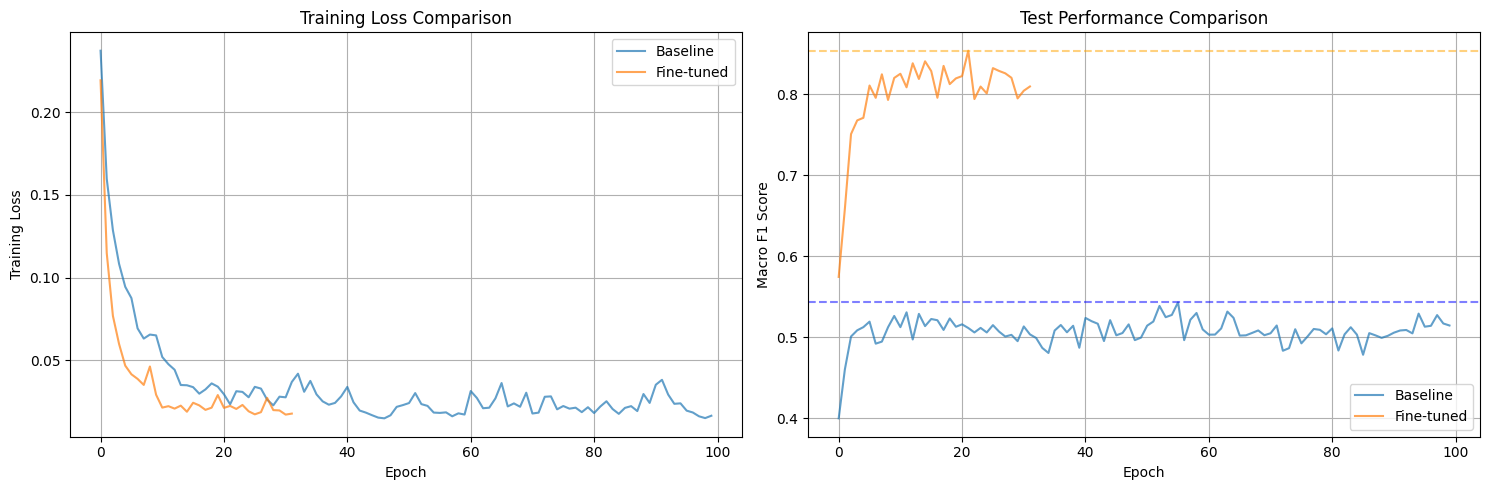


Results saved to /content/drive/MyDrive/MIR/L3AC


In [ ]:
# Compare results
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)

# Re-initialize the MLP models
input_dim = 512
model = EffectClassifierMLP(input_dim=input_dim, num_classes=len(ALL_EFFECTS)).to(device)
model_ft = EffectClassifierMLP(input_dim=input_dim, num_classes=len(ALL_EFFECTS)).to(device)

# Load best models
model.load_state_dict(torch.load(DATASET_DIR / "best_mlp_model.pth"))
model_ft.load_state_dict(torch.load(DATASET_DIR / "best_mlp_finetuned.pth"))

#Calculate Metrics for Fine-Tuned Model
model_ft.eval()
all_preds_ft = []
all_labels_ft = []

with torch.no_grad():
    for features_batch, labels_batch in test_loader_ft:
        features_batch = features_batch.to(device)
        outputs = model_ft(features_batch)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds_ft.append(preds)
        all_labels_ft.append(labels_batch.numpy())

all_preds_ft = np.vstack(all_preds_ft)
all_labels_ft = np.vstack(all_labels_ft)

micro_f1_ft = f1_score(all_labels_ft, all_preds_ft, average='micro')
macro_f1_ft = f1_score(all_labels_ft, all_preds_ft, average='macro')
per_class_f1_ft = f1_score(all_labels_ft, all_preds_ft, average=None)

print("="*60)
print("BASELINE EVALUATION RESULTS(NOT FINETUNED)")
print("="*60)
print(f"Micro F1: {micro_f1_final:.4f}")
print(f"Macro F1: {macro_f1_final:.4f}")
print(f"\nPer-class F1 scores:")
for effect, f1 in zip(ALL_EFFECTS, per_class_f1):
    print(f"  {effect:20s}: {f1:.4f}")

print("\n" + "="*60)
print("\nFINE-TUNED L3AC:")
print(f"  Micro F1: {micro_f1_ft:.4f}")
print(f"  Macro F1: {macro_f1_ft:.4f}")

print("\n" + "="*60)
print("PER-CLASS F1 SCORES (FINE-TUNED)")
print("="*60)
print(f"{'Effect':<20} {'F1 Score':<10}")
print("-" * 30)
for effect, f1 in zip(ALL_EFFECTS, per_class_f1_ft):
    print(f"{effect:<20} {f1:.4f}")

print("="*60)
print("\nIMPROVEMENT:")
print(f"  Micro F1: {(micro_f1_ft - micro_f1_final)*100:+.2f}%")
print(f"  Macro F1: {(macro_f1_ft - macro_f1_final)*100:+.2f}%")
print("\nPer-class F1 Improvement: \n")
print(f"{'Effect':<20} {'Baseline F1':<15} {'Fine-tuned F1':<18} {'Improvement (%)':<20}")
print("-" * 73)
for i, effect in enumerate(ALL_EFFECTS):
    baseline_f1 = per_class_f1[i]
    finetuned_f1 = per_class_f1_ft[i]
    if baseline_f1 == 0 and finetuned_f1 == 0:
        improvement_percent = 0.0 # No improvement if both are 0
    elif baseline_f1 == 0:
        improvement_percent = 100.0 if finetuned_f1 > 0 else 0.0 # Infinite improvement from zero, cap at 100
    else:
        improvement_percent = ((finetuned_f1 - baseline_f1) / baseline_f1) * 100
    print(f"{effect:<20} {baseline_f1:<15.4f} {finetuned_f1:<18.4f} {improvement_percent:<+20.2f}")

print("="*60)
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training curves comparison
axes[0].plot(train_losses, label='Baseline', alpha=0.7)
axes[0].plot(train_losses_ft, label='Fine-tuned', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True)

# F1 scores comparison
axes[1].plot(test_f1_scores, label='Baseline', alpha=0.7)
axes[1].plot(test_f1_scores_ft, label='Fine-tuned', alpha=0.7)
axes[1].axhline(y=best_f1, color='blue', linestyle='--', alpha=0.5)
axes[1].axhline(y=best_f1_ft, color='orange', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Macro F1 Score')
axes[1].set_title('Test Performance Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(Path(PROJECT_DIR) / "comparison_results.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResults saved to {PROJECT_DIR}")

Baseline test features shape: (1175, 512)
Fine-tuned test features shape: (1175, 512)
Applying t-SNE to baseline features...
Applying t-SNE to fine-tuned features...


<Figure size 1600x700 with 0 Axes>

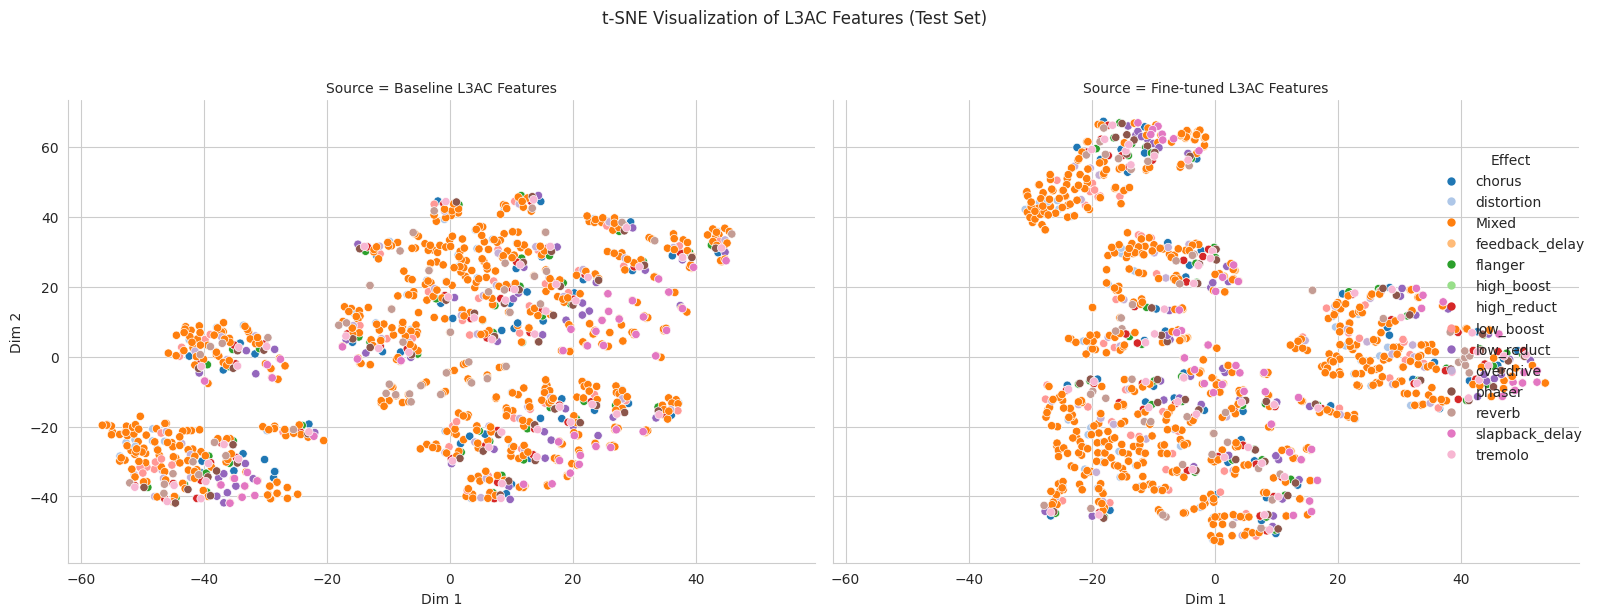

t-SNE visualization saved to /content/drive/MyDrive/MIR/L3AC/tsne_feature_comparison.png


In [ ]:
# Load original features and labels (from the pre-tuned model)
# These are `all_features` and `all_labels`

# Load fine-tuned features and labels
finetuned_features = np.load(DATASET_DIR / "finetuned_l3ac_features.npy")
finetuned_labels = np.load(DATASET_DIR / "finetuned_labels.npy")

# For simplicity, we'll focus on the test set for visualization
# Using the indices from the previous split to ensure consistency
# For baseline features
X_test_baseline = all_features[test_idx]
y_test_baseline = all_labels[test_idx]

# For fine-tuned features
# Note: The 'finetuned_features' were extracted from 'rendered_data', which was already split.
# So we need to use the same `test_idx` to get the corresponding fine-tuned test set.
# Assuming `finetuned_features` and `finetuned_labels` are in the same order as `all_features` and `all_labels`.
# It's safer to re-derive X_test_ft and y_test_ft from the loaded data

# Re-create the test splits for finetuned features (if needed, based on how they were saved)
# The previous cell 'UeUrrxIoJh7i' used `train_test_split` directly on `finetuned_features`,
# so we should use those exact splits if we want consistent visualization with the MLP evaluation.
# However, to compare directly with the baseline `X_test_baseline` (which was split based on original stems),
# we should apply the `test_idx` to `finetuned_features` as well.

# Let's verify if finetuned_features and finetuned_labels maintain the same order as reconstructed_data. If so,
# we can use the same test_idx.
# Based on cell `t8YQrlJTJgnw`, `finetuned_features` and `finetuned_labels` are appended in the order of `rendered_data`.
# Thus, we can use the original `test_idx` from `reconstructed_data` (which was loaded into `rendered_data`).

X_test_ft_viz = finetuned_features[test_idx]
y_test_ft_viz = finetuned_labels[test_idx]


print(f"Baseline test features shape: {X_test_baseline.shape}")
print(f"Fine-tuned test features shape: {X_test_ft_viz.shape}")

# Randomly sample a subset for t-SNE if dataset is too large (t-SNE can be slow)
# For this dataset size (1175 samples in test set), it should be manageable.

# Apply t-SNE
print("Applying t-SNE to baseline features...")
tsne_baseline = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_test_baseline)
print("Applying t-SNE to fine-tuned features...")
tsne_finetuned = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_test_ft_viz)

# Prepare data for plotting
def create_tsne_df(tsne_results, labels, title):
    df = pd.DataFrame(tsne_results, columns=['Dim 1', 'Dim 2'])
    # Map multi-hot labels to a single primary label for coloring
    primary_labels = []
    for label_row in labels:
        active_effects = [ALL_EFFECTS[i] for i, val in enumerate(label_row) if val == 1]
        if len(active_effects) == 1:
            primary_labels.append(active_effects[0])
        elif len(active_effects) > 1:
            primary_labels.append('Mixed') # or any other way to represent multiple
        else:
            primary_labels.append('No Effect')
    df['Effect'] = primary_labels
    df['Source'] = title
    return df

df_baseline = create_tsne_df(tsne_baseline, y_test_baseline, 'Baseline L3AC Features')
df_finetuned = create_tsne_df(tsne_finetuned, y_test_ft_viz, 'Fine-tuned L3AC Features')

# Combine for unified plotting
df_combined = pd.concat([df_baseline, df_finetuned])

# Plotting
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

sns.relplot(
    data=df_combined,
    x='Dim 1', y='Dim 2', hue='Effect', col='Source',
    height=6, aspect=1.2, palette='tab20', legend='full'
)

plt.suptitle('t-SNE Visualization of L3AC Features (Test Set)', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.savefig(Path(PROJECT_DIR) / "tsne_feature_comparison.png", dpi=300)
plt.show()

print(f"t-SNE visualization saved to {Path(PROJECT_DIR) / 'tsne_feature_comparison.png'}")